# Pseudolikelihood Maximisation (PLM)

## 1. PLM for observed data

### 1.1 Equations

In [1]:
from sympy import symbols, Sum, IndexedBase, ln, diff, Piecewise, Ne, simplify, exp
import sympy as sp

# Define the symbols for dimensions and indices
N, d = symbols('N d', integer=True)
t, i, j = symbols('t i j', integer=True)

# Define symbolic indexed bases for J, h, and X
J = IndexedBase('J', shape=(d, d))
h = IndexedBase('h', shape=(d,))
X = IndexedBase('X', shape=(d, d))

# Define the sum for log-pseudolikelihood function
S = h[i] + Sum(Piecewise((J[i, j] * X[t, j], Ne(j, i))), (j, 1, d))

# Define the log-pseudolikelihood function LL according to the corrected expression
LL = Sum(-ln(1 + exp(-2 * X[t, i] * S)), (t, 1, N), (i, 1, d))
LL

Sum(Piecewise((-log(1 + exp(-2*(h[i] + Sum(J[i, j]*X[t, j], (j, 1, d)))*X[t, i])), Ne(i, j))), (t, 1, N), (i, 1, d))

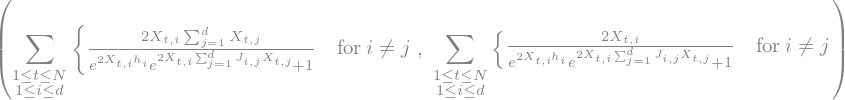

In [2]:
# Compute the symbolic gradients
grad_J_ij = diff(LL, J[i, j])
grad_h_i = diff(LL, h[i])

# Simplify the gradients
grad_J_ij_simplified = simplify(grad_J_ij)
grad_h_i_simplified = simplify(grad_h_i)

# Initialise pretty-printing
sp.init_printing(use_unicode=True)

# Display the expressions
grad_J_ij_simplified, grad_h_i_simplified

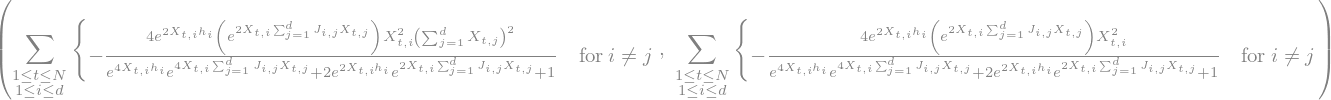

In [4]:
# Compute the symbolic second derivatives
hessian_J_ij = diff(grad_J_ij, J[i, j])
hessian_h_i = diff(grad_h_i, h[i])

# Simplify the second derivatives
hessian_J_ij_simplified = simplify(hessian_J_ij)
hessian_h_i_simplified = simplify(hessian_h_i)

# Display the expressions
hessian_J_ij_simplified, hessian_h_i_simplified

### 1.2. Implementation

In [27]:
import numpy as np
import pandas as pd
from Utility.decorators import timer

@timer
def log_pseudolikelihood_and_gradients_v1(J, h, X):
    """
    Initial code for calculating the log-pseudolikelihood and gradients.
    """
    N, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J = np.zeros_like(J)  # Initialise the gradient of J
    grad_h = np.zeros_like(h)  # Initialise the gradient of h

    for t in range(N):
        for i in range(d):
            # Common terms
            x_i = X[t, i]
            S = h[i]

            # Compute S
            for j in range(d):
                if j != i:
                    S += J[i, j] * X[t, j]
                    
            # Update log-likelihood
            log_likelihood += x_i * S - np.log(2 * np.cosh(S))

            grad_term = x_i - np.tanh(S)
            
            # Update gradient of h
            grad_h[i] += grad_term
            
            # Update gradient of J
            for j in range(d):
                if j != i:
                    grad_J[i, j] += X[t, j] * grad_term
                    grad_J[j, i] = grad_J[i, j]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v2(J, h, X):
    """
    Streamlined code for calculating the log-pseudolikelihood and gradients.
    """
    N, d = X.shape  # Number of samples and dimensions
    log_likelihood, grad_J, grad_h = 0, np.zeros_like(J), np.zeros_like(h)

    for t in range(N):
        for i in range(d):
            # Common terms
            x_i = X[t, i]
            S = np.dot(J[i, :], X[t, :]) + h[i]
            grad_term = x_i - np.tanh(S)

            # Update log-likelihood
            log_likelihood += x_i * S - np.log(2 * np.cosh(S))

            # Update gradients
            grad_h[i] += grad_term
            mask = np.ones(d, dtype=bool)
            mask[i] = False
            grad_J[i, mask] += X[t, mask] * grad_term
            grad_J[mask, i] = grad_J[i, mask]

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v3(J, h, X):
    """
    Vectorised code for super speedy performance.
    """
    d = X.shape[1]  # Number of dimensions
    grad_J, grad_h = np.zeros_like(J), np.zeros_like(h)

    # Compute S, broadcasting h
    S = X @ J + h

    # Update log-likelihood
    log_likelihood = np.sum(X * S - np.log(2 * np.cosh(S)))

    grad_term = X - np.tanh(S)
    grad_h = np.sum(grad_term, axis=0)

    # Compute the gradient for J, excluding the diagonal
    # Create a mask to zero out diagonal contributions in the grad_J calculation
    mask = np.ones_like(J) - np.eye(d)
    grad_J = (grad_term.T @ X + X.T @ grad_term) * mask

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v4(J, h, X):
    """
    Different formulation.
    """
    N, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J = np.zeros_like(J)  # Initialise the gradient of J
    grad_h = np.zeros_like(h)  # Initialise the gradient of h

    for t in range(N):
        for i in range(d):
            # Common terms
            x_i = X[t, i]
            S = h[i]

            # Compute S
            for j in range(d):
                if j != i:
                    S += J[i, j] * X[t, j]
                    
            # Update log-likelihood
            log_likelihood += - np.log(1 + np.exp(-2 * x_i * S))

            grad_term = 2 * x_i / (1 + np.exp(2 * x_i * S))
            
            # Update gradients
            grad_h[i] += grad_term
            mask = np.ones(d, dtype=bool)
            mask[i] = False
            grad_J[i, mask] += X[t, mask] * grad_term
            grad_J[mask, i] = grad_J[i, mask]

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v5(J, h, X):
    d = X.shape[1]  # Number of dimensions
    grad_J, grad_h = np.zeros_like(J), np.zeros_like(h)

    # Compute S, broadcasting h
    S = X @ J + h

    # Update log-likelihood
    log_likelihood = np.sum(- np.log(1 + np.exp(-2 * X * S)))

    grad_term = 2 * X / (1 + np.exp(2 * X * S))
    grad_h = np.sum(grad_term, axis=0)

    # Compute the gradient for J, excluding the diagonal
    # Create a mask to zero out diagonal contributions in the grad_J calculation
    mask = np.ones_like(J) - np.eye(d)
    grad_J = (grad_term.T @ X + X.T @ grad_term) * mask

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v6(J, h, X):
    d = X.shape[1]  # Number of dimensions
    grad_J, grad_h = np.zeros_like(J), np.zeros_like(h)

    # Compute S, broadcasting h
    S = X @ J + h
    S_exp = np.exp(2 * X * S)

    # Update log-likelihood
    log_likelihood = np.sum(np.log(1 + 1/S_exp))

    grad_term = 2 * X / (1 + S_exp)
    grad_h = np.sum(grad_term, axis=0)

    # Compute the gradient for J, excluding the diagonal
    # Create a mask to zero out diagonal contributions in the grad_J calculation
    mask = np.ones_like(J) - np.eye(d)
    grad_J = (grad_term.T @ X + X.T @ grad_term) * mask

    # Return the negative likelihood and gradients for minimisation
    return log_likelihood, -grad_J, -grad_h

# Define test inputs
X = pd.read_csv('Results/data_matrix_DKK.csv').drop(columns=["Date"]).to_numpy()
N, d = X.shape

# Initialise J as a symmetric matrix with zeros on the diagonal
# Elements are drawn from a uniform distribution over [-1, 1]
J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)  # Upper triangular part with 1 offset to exclude diagonal
J = J_upper + J_upper.T  # Symmetric matrix with zeros on the diagonal

# Initialise h as a one-dimensional array (vector) of size d
# Elements are drawn from a uniform distribution over [-1, 1]
h = np.random.uniform(-1, 1, size=d)

def compare_pseudolikelihood_functions(J, h, X):
    # Function names in a dictionary for iteration
    functions = {
        'v1': log_pseudolikelihood_and_gradients_v1,
        'v2': log_pseudolikelihood_and_gradients_v2,
        'v3': log_pseudolikelihood_and_gradients_v3,
        'v4': log_pseudolikelihood_and_gradients_v4,
        'v5': log_pseudolikelihood_and_gradients_v5,
        'v6': log_pseudolikelihood_and_gradients_v6
    }

    # Run each function and store results
    results = {name: func(J, h, X) for name, func in functions.items()}

    # Print results for each function
    for name, result in results.items():
        print(f"\nFunction {name} Results:")
        print("-log_likelihood:", result[0])
        print("-grad_J:\n", result[1][:3, :3])  # Print a 3x3 submatrix
        print(f"-grad_h:{result[2][:3]}")  # Print first 3 elements

    # Define specific pairs to compare
    comparison_pairs = [('v4', 'v5'), ('v4', 'v6')]

    # Compare results between each specified pair of functions
    for name1, name2 in comparison_pairs:
        result1, result2 = results[name1], results[name2]
        ll_same = np.allclose(result1[0], result2[0])
        grad_J_same = np.allclose(result1[1], result2[1])
        grad_h_same = np.allclose(result1[2], result2[2])
        print(f"{name1} vs {name2}: "
              f"LL: {'Same' if ll_same else 'Different'}, "
              f"Grad_J: {'Same' if grad_J_same else 'Different'}, "
              f"Grad_h: {'Same' if grad_h_same else 'Different'}")

compare_pseudolikelihood_functions(J, h, X)

'log_pseudolikelihood_and_gradients_v1' execution time: 2.695092 seconds
'log_pseudolikelihood_and_gradients_v2' execution time: 1.046752 seconds
'log_pseudolikelihood_and_gradients_v3' execution time: 0.050694 seconds
'log_pseudolikelihood_and_gradients_v4' execution time: 2.039133 seconds
'log_pseudolikelihood_and_gradients_v5' execution time: 0.683303 seconds
'log_pseudolikelihood_and_gradients_v6' execution time: 0.084686 seconds

Function v1 Results:
-log_likelihood: 296394.61675601726
-grad_J:
 [[   -0.         -6233.94391051 -4027.19501383]
 [-6233.94391051    -0.         -4274.08807752]
 [-4027.19501383 -4274.08807752    -0.        ]]
-grad_h:[  586.05444353 -1002.6869335    535.49814835]

Function v2 Results:
-log_likelihood: 296394.6167560174
-grad_J:
 [[   -0.         -6233.94391051 -4027.19501383]
 [-6233.94391051    -0.         -4274.08807752]
 [-4027.19501383 -4274.08807752    -0.        ]]
-grad_h:[  586.05444353 -1002.6869335    535.49814835]

Function v3 Results:
-log_

### 1.3 Computing Hessian to check convexity

In [28]:
import numpy as np
import pandas as pd
from autograd import hessian
import autograd.numpy as anp

# Load data and initialise parameters
X = pd.read_csv('Results/data_matrix_DKK.csv').drop(columns=["Date"]).to_numpy()
N, d = X.shape
J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)
J = J_upper + J_upper.T
h = np.random.uniform(-1, 1, size=d)

# Flatten J and h
params = np.concatenate([J[np.triu_indices(d, 1)], h])

def reconstruct_J_and_h(flattened_array, d):
    J_upper_tri = flattened_array[:d * (d - 1) // 2]
    h = flattened_array[d * (d - 1) // 2:]

    # Construct the symmetric J matrix from the upper triangular part
    J = anp.zeros((d, d))
    rows = []
    start = 0
    for i in range(d):
        end = start + d - i - 1

        # Construct the upper part of the row
        upper_part = J_upper_tri[start:end]

        # Fill the rest with zeros (for the diagonal and the lower part)
        zeros = anp.zeros(i + 1)  # One extra zero for the diagonal

        # Combine to form the complete row
        row = anp.concatenate([zeros, upper_part])
        rows.append(row)

        start = end

    J = anp.array(rows)
    J += J.T  # Symmetrise the J matrix

    return J, h

# Define the log_pseudolikelihood function
def log_pseudolikelihood(params, X):
    J, h = reconstruct_J_and_h(params, X.shape[1])
    S = X @ J + h
    return anp.sum(anp.log(1 + anp.exp(-2 * X * S)))

# Check reconstruction and convexity
J_reconstructed, h_reconstructed = reconstruct_J_and_h(params, d)
J_comparison = np.allclose(J, J_reconstructed)
h_comparison = np.allclose(h, h_reconstructed)
print(f"Are the reconstructed parameters the same as the originals? J: {J_comparison}, h: {h_comparison}")

# Compute the Hessian for J and h
H = hessian(log_pseudolikelihood)(params, X)

# Check if the Hessians are positive semi-definite and analyse eigenvalues
def check_convexity_and_eigenvalues(H):
    eigvals = np.linalg.eigvals(H)
    is_convex = np.all(eigvals >= 0)
    num_negative = np.sum(eigvals < 0)
    min_eigval = np.min(eigvals)
    return is_convex, num_negative, min_eigval

is_convex, num_negative, min_eigval = check_convexity_and_eigenvalues(H)

# Print results
print("Hessian - Convex:", is_convex, "Min Eigenvalue:", min_eigval, "Negative Eigenvalues:", num_negative)

Are the reconstructed parameters the same as the originals? J: True, h: True
Hessian - Convex: True Min Eigenvalue: 168.70358953976336 Negative Eigenvalues: 0


In [ ]:
def sample_parameters(d, num_samples=100):
    for _ in range(num_samples):
        J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)
        h_sample = np.random.uniform(-1, 1, size=d)
        params_sample = np.concatenate([J_upper[np.triu_indices(d, 1)], h_sample])
        yield params_sample

num_samples = 10  # Adjust based on computational feasibility
for params_sample in sample_parameters(d, num_samples):
    H_sample = hessian(log_pseudolikelihood)(params_sample, X)
    is_convex, _, _ = check_convexity_and_eigenvalues(H_sample)
    if not is_convex:
        print("Found a point where the function is not convex")
        break
else:
    print("All sampled points indicate convexity")

All sampled points indicate convexity


### 1.4 Optimisation

Attempt 1 of optimisation successful, execution time: 0.803 seconds
Attempt 2 of optimisation successful, execution time: 0.415 seconds
Attempt 3 of optimisation successful, execution time: 0.429 seconds
Attempt 4 of optimisation successful, execution time: 0.318 seconds
Attempt 5 of optimisation successful, execution time: 0.369 seconds
Attempt 6 of optimisation successful, execution time: 0.377 seconds
Attempt 7 of optimisation successful, execution time: 0.358 seconds
Attempt 8 of optimisation successful, execution time: 0.272 seconds
Attempt 9 of optimisation successful, execution time: 0.326 seconds
Attempt 10 of optimisation successful, execution time: 0.360 seconds
Optimisation completed with averaged results after 10 successes.



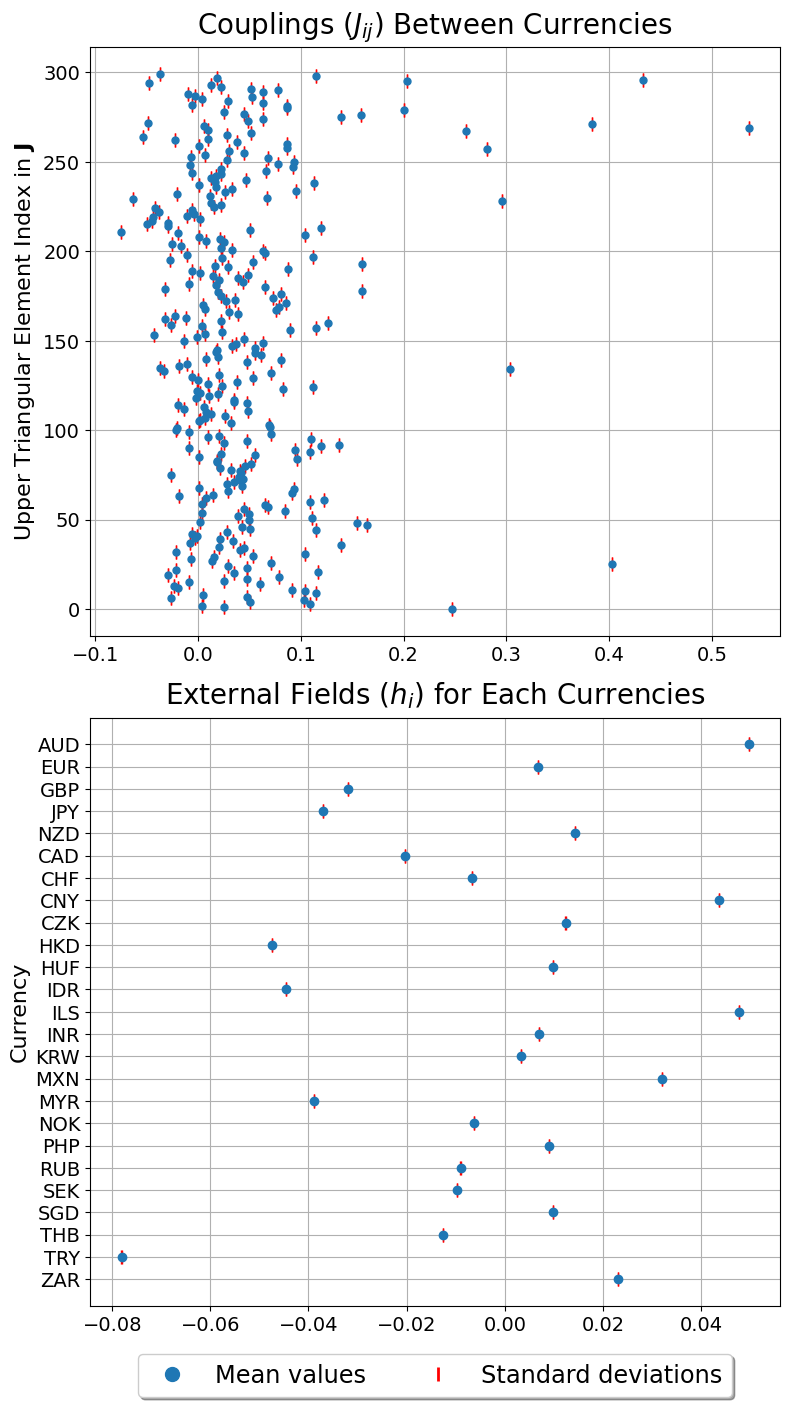

The optimised J matrix has been saved to 'Results/J.csv'.
The optimised h vector has been saved to 'Results/h.csv'.
The standard deviation of J matrix has been saved to 'Results/J_std.csv'.
The standard deviation of h vector has been saved to 'Results/h_std.csv'.


In [41]:
from Utility.IsingOptimiser import IsingOptimiser
J_file_path='Results/J.csv'
h_file_path='Results/h.csv'
J_std_file_path='Results/J_std.csv'
h_std_file_path='Results/h_std.csv'

ising_optimiser = IsingOptimiser('Results/data_matrix.csv')
ising_optimiser.train(100, 'vertical')
ising_optimiser.save_results(J_file_path, h_file_path, J_std_file_path, h_std_file_path)

In [2]:
import pandas as pd
import numpy as np

df_J_std = pd.read_csv('Results/J_std.csv')
J_std = df_J_std.where(np.triu(np.ones(df_J_std.shape), k=1).astype(bool)).stack().values
h_std = pd.read_csv('Results/h_std.csv', header=None)[1].values
parameters_std = np.concatenate((J_std, h_std))

# Calculate the mean of these upper triangle values
mean_std_dev = np.mean(parameters_std)
mean_std_dev

7.3609351519458066e-06

Attempt 1 of optimisation successful, execution time: 2.452 seconds
Attempt 2 of optimisation successful, execution time: 4.679 seconds
Attempt 3 of optimisation successful, execution time: 2.279 seconds
Attempt 4 of optimisation successful, execution time: 4.662 seconds
Attempt 5 of optimisation successful, execution time: 2.916 seconds
Attempt 6 of optimisation successful, execution time: 2.801 seconds
Attempt 7 of optimisation successful, execution time: 2.228 seconds
Attempt 8 of optimisation successful, execution time: 2.234 seconds
Attempt 9 of optimisation successful, execution time: 2.100 seconds
Attempt 10 of optimisation successful, execution time: 2.316 seconds
Optimisation completed with averaged results after 10 successes.



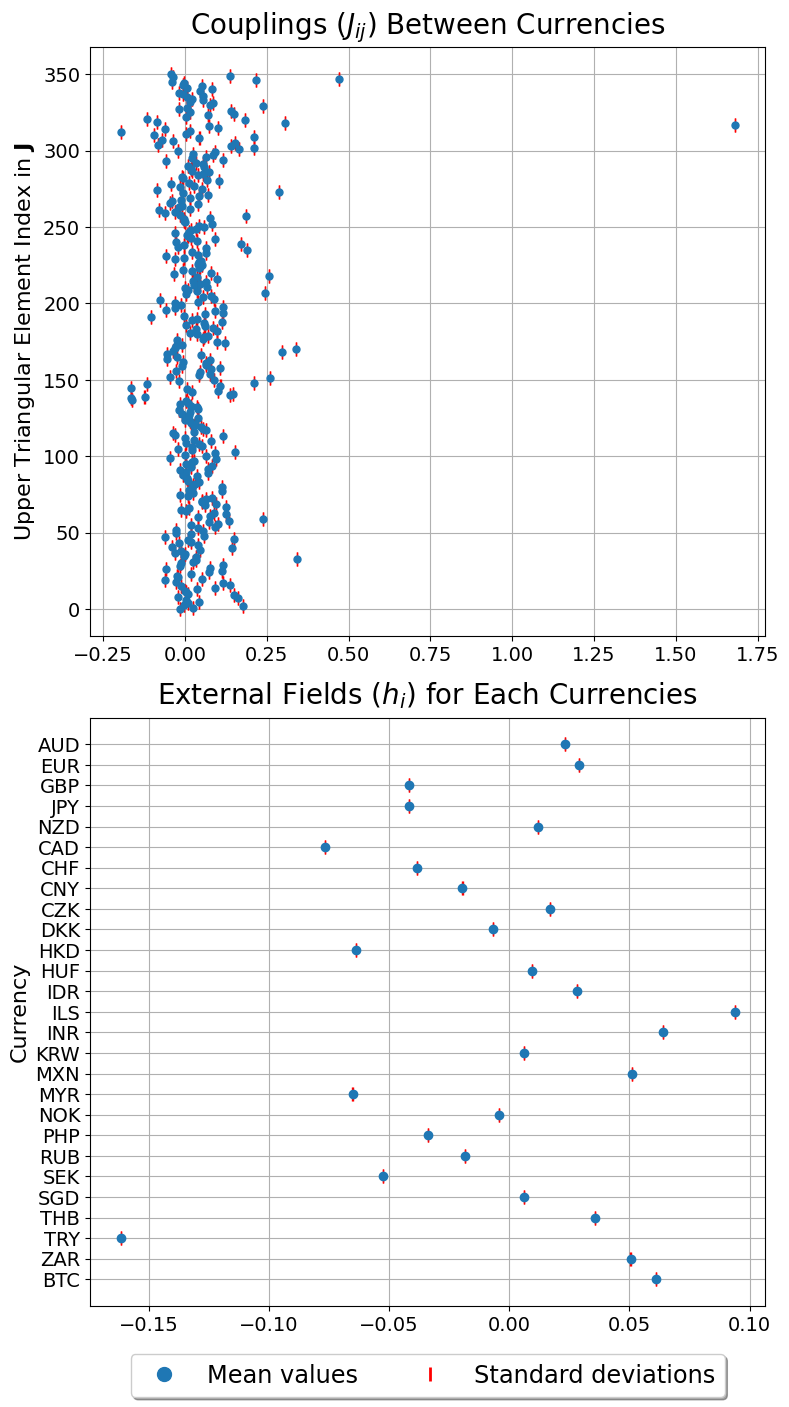

The optimised J matrix has been saved to 'Results/J_BTC.csv'.
The optimised h vector has been saved to 'Results/h_BTC.csv'.
The standard deviation of J matrix has been saved to 'None'.
The standard deviation of h vector has been saved to 'None'.


In [8]:
from Utility.IsingOptimiser import IsingOptimiser
J_file_path='Results/J_BTC.csv'
h_file_path='Results/h_BTC.csv'

ising_optimiser = IsingOptimiser('Results/data_matrix_BTC.csv')
ising_optimiser.train(100, 'vertical')
ising_optimiser.save_results(J_file_path, h_file_path, None, None)

Attempt 1 of optimisation successful, execution time: 0.536 seconds
Attempt 2 of optimisation successful, execution time: 0.397 seconds
Attempt 3 of optimisation successful, execution time: 0.413 seconds
Attempt 4 of optimisation successful, execution time: 0.455 seconds
Attempt 5 of optimisation successful, execution time: 0.401 seconds
Attempt 6 of optimisation successful, execution time: 0.497 seconds
Attempt 7 of optimisation successful, execution time: 1.165 seconds
Attempt 8 of optimisation successful, execution time: 1.132 seconds
Attempt 9 of optimisation successful, execution time: 0.463 seconds
Attempt 10 of optimisation successful, execution time: 0.631 seconds
Optimisation completed with averaged results after 10 successes.



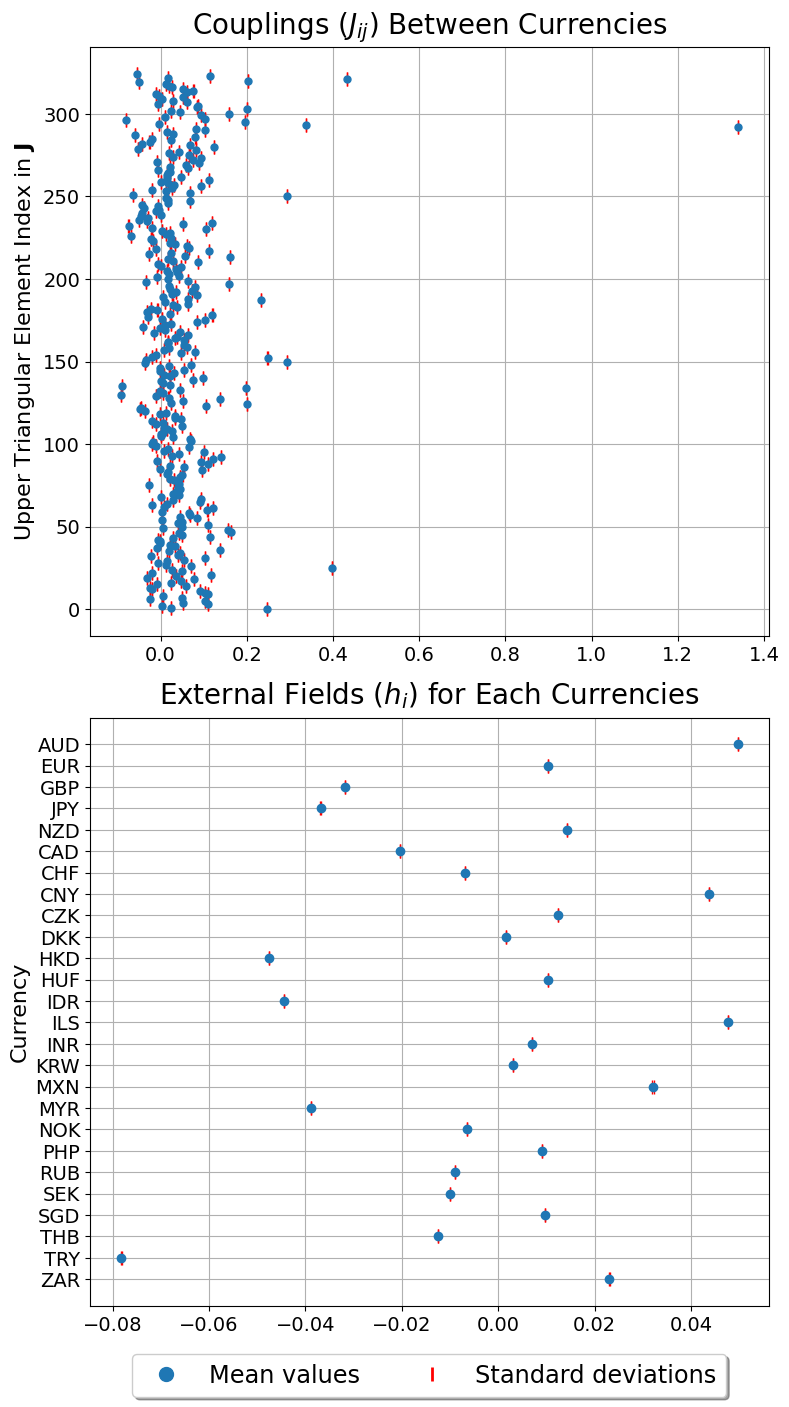

The optimised J matrix has been saved to 'Results/J_DKK.csv'.
The optimised h vector has been saved to 'Results/h_DKK.csv'.
The standard deviation of J matrix has been saved to 'None'.
The standard deviation of h vector has been saved to 'None'.


In [42]:
from Utility.IsingOptimiser import IsingOptimiser
J_file_path='Results/J_DKK.csv'
h_file_path='Results/h_DKK.csv'

ising_optimiser = IsingOptimiser('Results/data_matrix_DKK.csv')
ising_optimiser.train(100, 'vertical')
ising_optimiser.save_results(J_file_path, h_file_path, None, None)

### 1.5 Moving Averages

##### Analysing Moving Averages of J and h
- Smoothing: Moving averages smooth out short-term fluctuations, making it easier to identify long-term trends. 
- Highlighting Trends: If the purpose is understanding broader market trends or the impact of macroeconomic events (like financial crises), moving averages can provide a clearer picture by filtering out the "noise" of short-term volatility.
- Reduced Sensitivity to Outliers: By averaging over a period, the impact of outliers is reduced, which can lead to a more stable and reliable analysis, especially in volatile markets.

https://en.wikipedia.org/wiki/2020_stock_market_crash

In [2]:
import pandas as pd

# Load data
df = pd.read_csv('Results/data_matrix.csv')

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the number of unique years in the dataset
years = df['Date'].dt.year.unique()

# Calculate the number of trading days per year
trading_days_per_year = df.groupby(df['Date'].dt.year).size()
trading_days_per_year

Date
2006    163
2007    261
2008    262
2009    261
2010    261
2011    260
2012    261
2013    261
2014    261
2015    261
2016    261
2017    260
2018    261
2019    260
2020    262
2021    261
2022    260
2023    201
dtype: int64

Attempt 1 of optimisation successful, execution time: 0.031 seconds
Attempt 2 of optimisation successful, execution time: 0.023 seconds
Attempt 3 of optimisation successful, execution time: 0.017 seconds
Attempt 4 of optimisation successful, execution time: 0.019 seconds
Attempt 5 of optimisation successful, execution time: 0.018 seconds
Attempt 6 of optimisation successful, execution time: 0.019 seconds
Attempt 7 of optimisation successful, execution time: 0.019 seconds
Attempt 8 of optimisation successful, execution time: 0.020 seconds
Attempt 9 of optimisation successful, execution time: 0.020 seconds
Attempt 10 of optimisation successful, execution time: 0.021 seconds
Optimisation completed with averaged results after 10 successes.

Attempt 1 of optimisation successful, execution time: 0.019 seconds
Attempt 2 of optimisation successful, execution time: 0.022 seconds
Attempt 3 of optimisation successful, execution time: 0.011 seconds
Attempt 4 of optimisation successful, execution t

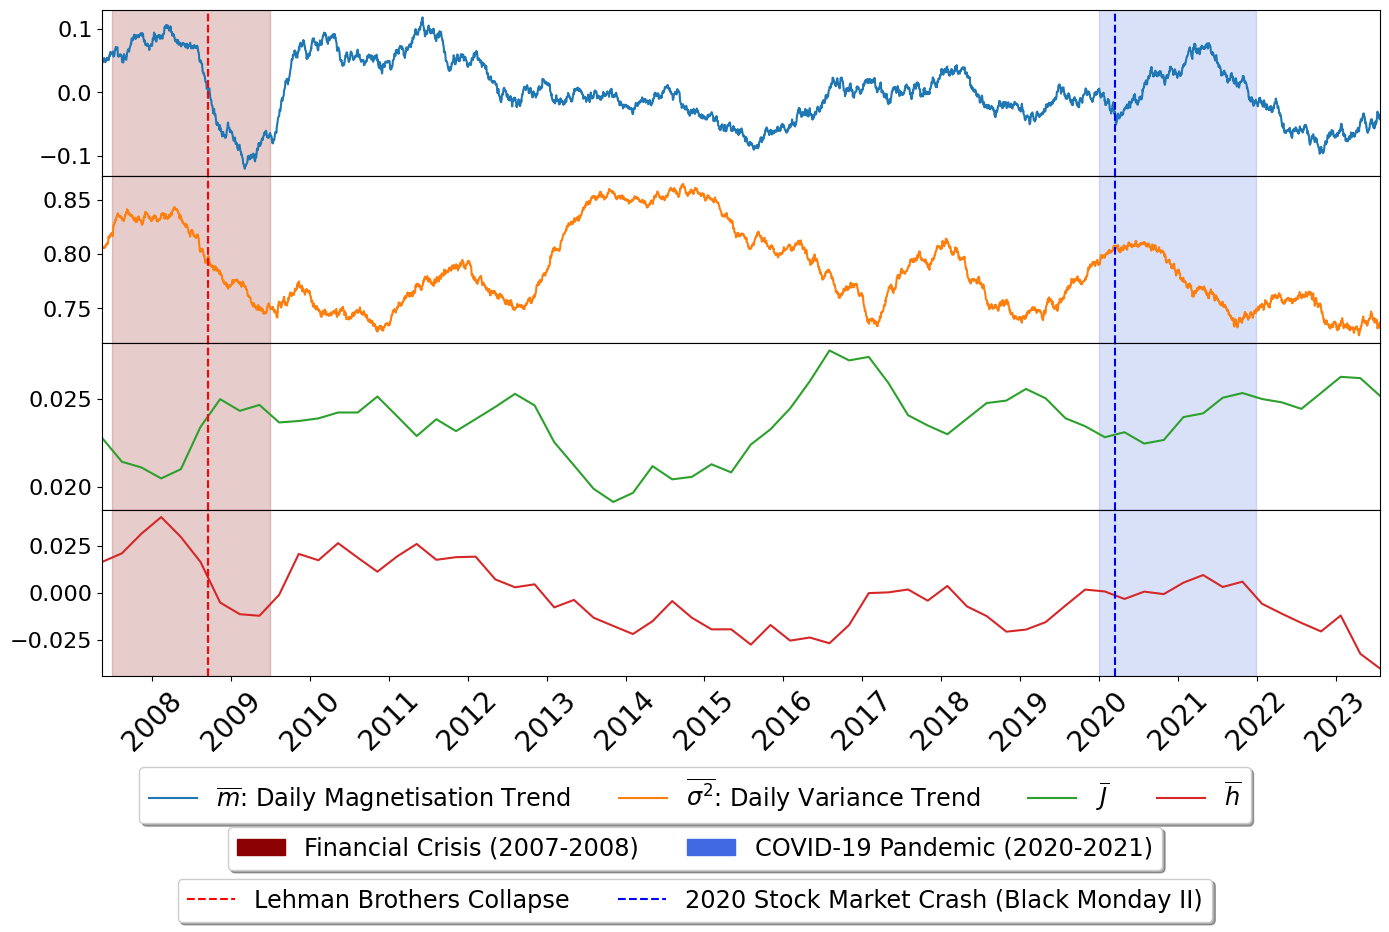

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import os
from datetime import datetime
from Utility.IsingOptimiser import IsingOptimiser

# Define parameters for the moving window
# This calculation takes into account the leap years by using 365.25 days as the average number of days per year
window_size = 260  # Approximately one year of trading days
step_size = 65  # Approximately one quarter of a year

# Lists to store moving average data
moving_avg_dates = []
J_moving_averages = []
h_moving_averages = []

for start in range(0, len(df) - window_size + 1, step_size):
    end = start + window_size
    subset = df.iloc[start:end]
    subset_file_path = f'temp_subset_{start}.csv'
    subset.to_csv(subset_file_path, index=False)
    
    # Initialise and train the IsingOptimiser with the subset
    ising_optimiser = IsingOptimiser(subset_file_path)
    ising_optimiser.train(100)  # Number of optimisations
    
    # Average only the upper triangle of J (excluding the diagonal)
    J_mean_upper_triangle = np.triu(ising_optimiser.J_optimised, k=1).mean()
    
    # Extract the date for plotting
    moving_avg_dates.append(subset['Date'].iloc[-1])
    
    # Store the average of the upper triangle of J and mean of h
    J_moving_averages.append(J_mean_upper_triangle)
    h_moving_averages.append(ising_optimiser.h_optimised.mean())
    
    # Delete the temporary subset file
    os.remove(subset_file_path)

# Define the function to annotate periods
def annotate_period(ax, start_date, end_date, label, color, alpha=0.2):
    start = mdates.date2num(datetime.strptime(start_date, '%Y-%m-%d'))
    end = mdates.date2num(datetime.strptime(end_date, '%Y-%m-%d'))
    ax.axvspan(start, end, color=color, alpha=alpha, label=label)

# Calculate the daily average of all currency pairs
daily_averages = df.drop('Date', axis=1).mean(axis=1)
daily_moving_averages = daily_averages.rolling(window=window_size).mean()

# Calculate the daily variance of all currency pairs
daily_variances = df.drop('Date', axis=1).var(axis=1)
daily_variance_moving_averages = daily_variances.rolling(window=window_size).mean()

# Add the daily moving average to the moving average dates list for plotting
daily_moving_avg_dates = df['Date'][window_size - 1:]
variance_moving_avg_dates = df['Date'][window_size - 1:]

# Convert the list of strings to datetime
daily_moving_avg_dates = pd.to_datetime(daily_moving_avg_dates)
variance_moving_avg_dates = pd.to_datetime(variance_moving_avg_dates)

# Ensure that daily_moving_averages and daily_moving_avg_dates are aligned
# Drop NaN values from daily_moving_averages
daily_moving_averages = daily_moving_averages.dropna()
daily_variance_moving_averages = daily_variance_moving_averages.dropna()

# Ensure the annotation dates are also datetime objects
lehman_collapse_date = datetime.strptime('2008-09-15', '%Y-%m-%d')
covid_crash_date = datetime.strptime('2020-03-16', '%Y-%m-%d')

# Define colors for different plot elements for consistency
color_data = 'C0' # Color for the moving average of data
color_J = 'C2'  # Color for the moving average of J
color_h = 'C3'  # Color for the moving average of h
color_financial_crisis = 'darkred'  # Color for the financial crisis period
color_covid_pandemic = 'royalblue'  # Color for the COVID-19 pandemic period
color_lehman = 'red'  # Color for the Lehman Brothers collapse annotation
color_covid_crash = 'blue'  # Color for the COVID-19 market crash annotation

# Plotting the moving averages with the annotations and shaded regions
fig, axs = plt.subplots(4, 1, figsize=(14, 8), sharex=True, gridspec_kw={'hspace': 0})

# Plot moving average of the daily average
axs[0].plot(daily_moving_avg_dates, daily_moving_averages, label='Rolling Averages of Daily Average Magnetisation', color=color_data)

# Plot moving average of variance
color_variance = 'C1'  # Color for the moving average of variance
axs[1].plot(variance_moving_avg_dates, daily_variance_moving_averages, label='Rolling Averages of Variance of Spin', color=color_variance)

# Plot moving average of J
axs[2].plot(moving_avg_dates, J_moving_averages, label='Moving Averages of J', color=color_J)
axs[2].xaxis.tick_bottom()

# Plot moving average of h
axs[3].plot(moving_avg_dates, h_moving_averages, label='Moving Averages of h', color=color_h)
axs[3].xaxis.tick_bottom()

# Layout to include three separate legend "rows"
legend_row_1 = [
    mlines.Line2D([], [], color=color_data, label=r'$\overline{m}$: Daily Magnetisation Trend', linewidth=1.5),
    mlines.Line2D([], [], color=color_variance, label=r'$\overline{\sigma^2}$: Daily Variance Trend', linewidth=1.5),
    mlines.Line2D([], [], color=color_J, label=r'$\overline{\mathbf{\mathit{J}}}$', linewidth=1.5),
    mlines.Line2D([], [], color=color_h, label=r'$\overline{\mathbf{\mathit{h}}}$', linewidth=1.5)
]

legend_row_2 = [
    mpatches.Patch(color=color_financial_crisis, label='Financial Crisis (2007-2008)'),
    mpatches.Patch(color=color_covid_pandemic, label='COVID-19 Pandemic (2020-2021)')
]

legend_row_3 = [
    mlines.Line2D([], [], color=color_lehman, linestyle='--', label='Lehman Brothers Collapse'),
    mlines.Line2D([], [], color=color_covid_crash, linestyle='--', label='2020 Stock Market Crash (Black Monday II)')
]

# Adjust the 'bbox_to_anchor' and 'loc' parameters for optimal positioning
fig.legend(handles=legend_row_1, loc='upper center', bbox_to_anchor=(0.5, -0.00), fancybox=True, shadow=True, ncol=4, fontsize='xx-large')
fig.legend(handles=legend_row_2, loc='upper center', bbox_to_anchor=(0.5, -0.075), fancybox=True, shadow=True, ncol=2, fontsize='xx-large')
fig.legend(handles=legend_row_3, loc='upper center', bbox_to_anchor=(0.5, -0.14), fancybox=True, shadow=True, ncol=2, fontsize='xx-large')

# Adjust the layout and plot the rest of the elements
for ax in axs:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(labelbottom=False, axis='y', labelsize=16)

    # Annotate periods with shaded regions and lines
    annotate_period(ax, '2007-07-01', '2009-06-30', 'Financial Crisis', color=color_financial_crisis)
    annotate_period(ax, '2020-01-01', '2021-12-31', 'COVID-19 Pandemic', color=color_covid_pandemic)
    ax.axvline(x=lehman_collapse_date, color=color_lehman, linestyle='--')
    ax.axvline(x=covid_crash_date, color=color_covid_crash, linestyle='--')

# Set plot limits to the first and last date
start_date = moving_avg_dates[0]
end_date = moving_avg_dates[-1]

# Later in your plotting code, after creating your axes (axs), set the x-axis limits
axs[0].set_xlim(start_date, end_date)
axs[1].set_xlim(start_date, end_date)
axs[2].set_xlim(start_date, end_date)

fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.xticks(fontsize=20, rotation=45)
plt.savefig("Images/moving_averages.svg", format="svg", bbox_inches='tight')
plt.show()

In [6]:
# Convert lists to pandas Series objects
data_moving_avg_series = pd.Series(daily_moving_averages.values, index=daily_moving_avg_dates)  # Use .values to align the length
variance_moving_avg_series = pd.Series(daily_variance_moving_averages.values, index=variance_moving_avg_dates)
J_moving_avg_series = pd.Series(J_moving_averages, index=pd.to_datetime(moving_avg_dates))
h_moving_avg_series = pd.Series(h_moving_averages, index=pd.to_datetime(moving_avg_dates))

# Descriptive Statistics
print("Descriptive Statistics for J, h, and Daily Average Moving Averages:")
descriptive_stats = pd.DataFrame({
    "Daily Avg Moving Average": data_moving_avg_series.describe(),
    "Daily Var Moving Average": variance_moving_avg_series.describe(),
    "J Moving Average": J_moving_avg_series.describe(),
    "h Moving Average": h_moving_avg_series.describe()
})
print(descriptive_stats)

# Correlation
correlation_matrix = pd.DataFrame({
    "Daily Avg Mov Avg": data_moving_avg_series,
    "Daily Var Mov Avg": variance_moving_avg_series,
    "J Moving Average": J_moving_avg_series,
    "h Moving Average": h_moving_avg_series
}).corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

Descriptive Statistics for J, h, and Daily Average Moving Averages:
       Daily Avg Moving Average  Daily Var Moving Average  J Moving Average  \
count               4474.000000               4474.000000         69.000000   
mean                   0.001459                  0.784191          0.071227   
std                    0.081391                  0.049930          0.035126   
min                   -0.353846                  0.637333          0.033589   
25%                   -0.049538                  0.747692          0.048611   
50%                    0.001846                  0.778256          0.057873   
75%                    0.054769                  0.823179          0.084669   
max                    0.219692                  0.916103          0.238147   

       h Moving Average  
count         69.000000  
mean           0.032449  
std            0.276395  
min           -0.307091  
25%           -0.056904  
50%            0.001761  
75%            0.050917  
max         

##### Interpretation:
- Peaks at Specific Lags: Significant peaks in the autocorrelation plot (outside the blue confidence interval) at specific lags indicate a relationship between the series and its past values. This might suggest seasonality or momentum.
- Slow Decay: A slow decay in autocorrelation values suggests a long-lasting effect where past values influence future values for an extended period.
- Rapid Drop to Low Values: A rapid drop suggests that the time series does not heavily depend on its past values, indicating a more random or efficient market behaviour.
- Comparing Autocorrelation Patterns: Differences in the autocorrelation patterns of J and h versus the daily averages can illuminate how interaction strengths and external influences behave relative to the overall market movements.

## 2. PLM including the hidden variable (Boltzmann Machine)

### 2.1 Equations

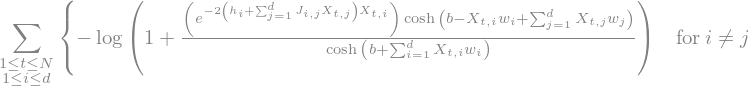

In [21]:
from sympy import symbols, Sum, IndexedBase, log, cosh, exp, diff, Piecewise, Ne, simplify, true
import sympy as sp

# Define the symbols for the dimensions and indices
N, d = symbols('N d', integer=True)
t, i, j = symbols('t i j', integer=True)
b = symbols('b', real=True)

# Define the symbolic indexed bases for J, h, w, and X
J = IndexedBase('J', shape=(d, d))
h = IndexedBase('h', shape=(d,))
w = IndexedBase('w', shape=(d,))
X = IndexedBase('X', shape=(N, d))

# Define S and S_u excluding the k = j term
S = Sum(Piecewise((J[i, j] * X[t, j], Ne(j, i))), (j, 1, d)) + h[i]
S_n = Sum(Piecewise((w[i] * X[t, i], true)), (i, 1, d)) + b
S_u = Sum(Piecewise((w[j] * X[t, j], Ne(j, i))), (j, 1, d)) + b

# Define the log-pseudolikelihood function LL
LL = Sum(-ln(1 + exp(-2 * X[t, i] * S)*cosh(-w[i]*X[t, i]+S_u)/cosh(S_n)), (t, 1, N), (i, 1, d))
LL

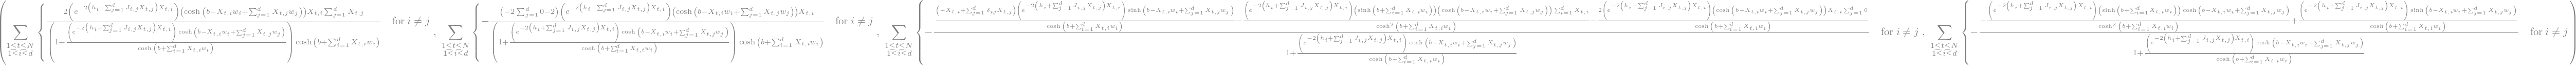

In [22]:
# Compute the symbolic gradients
grad_J_ij = diff(LL, J[i, j])
grad_h_i = diff(LL, h[i])
grad_w_i = diff(LL, w[i])
grad_b = diff(LL, b)

# Initialise pretty-printing
sp.init_printing(use_unicode=True)

# Display the expressions
grad_J_ij, grad_h_i, grad_w_i, grad_b

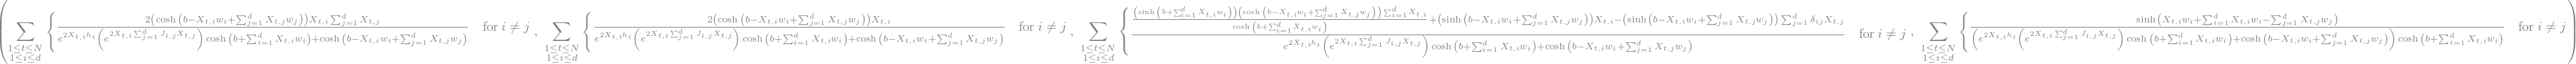

In [23]:
# Simplify the gradients (which only made things more complicated)
grad_J_ij_simplified = simplify(grad_J_ij)
grad_h_i_simplified = simplify(grad_h_i)
grad_w_i_simplified = simplify(grad_w_i)
grad_b_simplified = simplify(grad_b)

# Display the expressions
grad_J_ij_simplified, grad_h_i_simplified, grad_w_i_simplified, grad_b_simplified

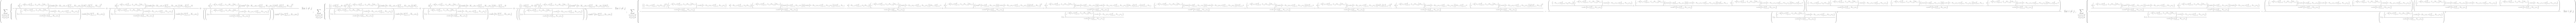

In [24]:
# Compute the symbolic second derivatives
hessian_J_ij = diff(grad_J_ij, J[i, j])
hessian_h_i = diff(grad_h_i, h[i])
hessian_w_j = diff(grad_w_i, w[i])
hessian_b = diff(grad_b, b)

# Display the expressions
hessian_J_ij, hessian_h_i, hessian_w_j, hessian_b

### 2.2 Implementation

In [30]:
import numpy as np
import pandas as pd
from Utility.decorators import timer

@timer
def log_pseudolikelihood_v1(J, h, w, b, X):
    N, d = X.shape  # Number of samples and dimensions

    # Initialise the log pseudolikelihood (LL) and the gradients of J, h, w and b
    log_likelihood = 0
    grad_J, grad_h, grad_w, grad_b = np.zeros_like(J), np.zeros_like(h), np.zeros_like(w), 0

    for t in range(N):
        for i in range(d):
            # Common terms
            x_i = X[t, i]
            w_i = w[i]
            S = np.dot(J[i, :], X[t, :]) + h[i]
            S_wb = np.dot(w, X[t, :]) + b - w_i * x_i # Without the contribution from the i-th term

            # components used in the LL and gradients
            exp_S = np.exp(S)
            cosh_pos = np.cosh(S_wb + w_i)
            cosh_neg = np.cosh(S_wb - w_i)
            sinh_pos = np.sinh(S_wb + w_i)
            sinh_neg = np.sinh(S_wb - w_i)
            denominator = exp_S * cosh_pos + cosh_neg / exp_S
            # Alternative expression for denominator
            denominator_2 = 2*np.cosh(-S)*np.cosh(S_wb)*np.cosh(w_i) - 2*np.sinh(-S)*np.sinh(S_wb)*np.sinh(w_i)

            # Update the new LL expression
            log_likelihood += (
                S * x_i +
                np.log(np.cosh(np.dot(w, X[t, :]) + b)) -
                np.log(denominator)
            )
            
            # grad_h update
            numerator_h = -cosh_neg / exp_S + exp_S * cosh_pos
            grad_h[i] += x_i - (numerator_h / denominator)

            # grad_w update
            numerator_w = -sinh_neg / exp_S + exp_S * sinh_pos
            grad_w[i] += x_i * np.tanh(S_wb + w_i * x_i) - (numerator_w / denominator)

            # grad_b update
            numerator_b = sinh_neg / exp_S + exp_S * sinh_pos
            grad_b += np.tanh(S_wb + w_i * x_i) - (numerator_b / denominator)

            # grad_J update
            numerator_J = -cosh_neg / exp_S + exp_S * cosh_pos
            for j in range(d):
                if j != i:
                    grad_J[i, j] += (x_i - (numerator_J / denominator)) * X[t, j]
                    grad_J[j, i] = grad_J[i, j]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

@timer
def log_pseudolikelihood_v2(J, h, w, b, X):
    N, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J, grad_h, grad_w, grad_b = np.zeros_like(J), np.zeros_like(h), np.zeros_like(w), 0

    for t in range(N):
        S_wb = np.dot(w, X[t, :]) + b
        for i in range(d):
            x_i = X[t, i]
            w_i = w[i]
            S = np.dot(J[i, :], X[t, :]) + h[i]
            S_wb_not_i = np.dot(w, X[t, :]) - w_i * x_i + b

            exp_S = np.exp(S)
            cosh_pos = np.cosh(S_wb_not_i + w_i)
            cosh_neg = np.cosh(S_wb_not_i - w_i)
            sinh_pos = np.sinh(S_wb_not_i + w_i)
            sinh_neg = np.sinh(S_wb_not_i - w_i)
            denominator = exp_S * cosh_pos + cosh_neg / exp_S

            # LL update
            log_likelihood += (
                S * x_i +
                np.log(np.cosh(S_wb)) -
                np.log(denominator)
            )

            # grad_h update
            numerator_h = -cosh_neg / exp_S + exp_S * cosh_pos
            grad_h[i] += x_i - (numerator_h / denominator)

            # grad_w update
            numerator_w = -sinh_neg / exp_S + exp_S * sinh_pos
            grad_w[i] += x_i * np.tanh(S_wb) - (numerator_w / denominator)

            # grad_b update
            numerator_b = sinh_neg / exp_S + exp_S * sinh_pos
            grad_b += np.tanh(S_wb) - (numerator_b / denominator)

            # grad_J update
            mask = np.ones(d, dtype=bool)
            mask[i] = False
            numerator_J = -cosh_neg / exp_S + exp_S * cosh_pos
            grad_J[i, mask] += (x_i - (numerator_J / denominator)) * X[t, mask]
            grad_J[mask, i] = grad_J[i, mask]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

@timer
def log_pseudolikelihood_v3(J, h, w, b, X):
    d = X.shape[1]  # Number of dimensions

    S = X @ J + h  # Broadcasting h
    S_wb = X @ w + b  # for all samples
    S_wb_not_i = X @ w.reshape(-1, 1) + b - X * w  # Broadcasting w

    # Calculate the components used in the log likelihood and gradients
    exp_S = np.exp(S)
    cosh_pos = np.cosh(S_wb_not_i + w)
    cosh_neg = np.cosh(S_wb_not_i - w)
    sinh_pos = np.sinh(S_wb_not_i + w)
    sinh_neg = np.sinh(S_wb_not_i - w)
    denominator = exp_S * cosh_pos + cosh_neg / exp_S

    log_numerator = np.log(np.cosh(S_wb.reshape(-1, 1)))  # Reshape to 2D
    log_denominator = np.log(denominator)  # Sum over dimensions for each sample

    # Combine the terms and sum over all samples to get the scalar log-likelihood
    log_likelihood = np.sum(X * S + log_numerator - log_denominator)

    # Gradients for h, w, and b
    numerator_h = -cosh_neg / exp_S + exp_S * cosh_pos
    grad_h = np.sum(X - numerator_h / denominator, axis=0)

    numerator_w = -sinh_neg / exp_S + exp_S * sinh_pos
    grad_w = np.sum(X.T * np.tanh(S_wb.T) - (numerator_w / denominator).T, axis=1)

    numerator_b = sinh_neg / exp_S + exp_S * sinh_pos
    grad_b = np.sum(np.tanh(S_wb.reshape(-1, 1)) - (numerator_b / denominator))

    # Gradient for J, excluding the diagonal
    mask = np.ones_like(J) - np.eye(d)
    numerator_J = -cosh_neg / exp_S + exp_S * cosh_pos
    grad_term_J = X - numerator_J / denominator
    grad_J = (grad_term_J.T @ X + X.T @ grad_term_J) * mask

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

@timer
def log_pseudolikelihood_v4(J, h, w, b, X):
    d = X.shape[1]  # Number of dimensions

    S = X @ J + h  # Broadcasting h
    S_n = X @ w + b  # for all samples
    S_u = X @ w.reshape(-1, 1) + b - 2 * X * w  # Broadcasting w

    # Calculate the components used in the log likelihood and gradients
    exp_S = np.exp(-2 * X * S)
    coshcosh = np.cosh(S_u) / np.cosh(S_n.reshape(-1, 1))

    # Update the new LL expression
    log_likelihood = np.sum(- np.log(1 + exp_S * coshcosh))

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, np.zeros_like(J), np.zeros_like(h), np.zeros_like(w), 0

# Read data
X = pd.read_csv('Results/data_matrix_DKK.csv').drop(columns=["Date"]).to_numpy()
J = pd.read_csv("Results/J_DKK.csv").values
h = pd.read_csv("Results/h_DKK.csv", header=None)[1].values
N, d = X.shape

# Initialise w and b
w = np.random.uniform(-1, 1, size=d)
b = np.random.uniform(-1, 1)

# Function to compare pseudolikelihood functions
def compare_pseudolikelihood_functions(J, h, w, b, X):
    functions = {
        'v1': log_pseudolikelihood_v1,
        'v2': log_pseudolikelihood_v2,
        'v3': log_pseudolikelihood_v3,
        'v4': log_pseudolikelihood_v4
    }

    results = {name: func(J, h, w, b, X) for name, func in functions.items()}

    for name, result in results.items():
        print(f"\nFunction {name} Results:")
        print("-log_likelihood:", result[0])
        print("-grad_J:\n", result[1][:3, :3])
        print(f"-grad_h:{result[2][:3]}")
        print(f"-grad_w:{result[3][:3]}")
        print(f"-grad_b:{result[4]}")

    comparison_pairs = [('v1', 'v3'), ('v1', 'v4')]

    # Compare results between each specified pair of functions
    for name1, name2 in comparison_pairs:
        result1, result2 = results[name1], results[name2]
        ll_same = np.allclose(result1[0], result2[0])
        grad_J_same = np.allclose(result1[1], result2[1])
        grad_h_same = np.allclose(result1[2], result2[2])
        grad_w_same = np.allclose(result1[3], result2[3])
        grad_b_same = np.allclose(result1[4], result2[4])
        print(f"{name1} vs {name2}: "
              f"LL: {'Same' if ll_same else 'Different'}, "
              f"Grad_J: {'Same' if grad_J_same else 'Different'}, "
              f"Grad_h: {'Same' if grad_h_same else 'Different'}, "
              f"Grad_w: {'Same' if grad_w_same else 'Different'}, "
              f"Grad_b: {'Same' if grad_b_same else 'Different'}")

compare_pseudolikelihood_functions(J, h, w, b, X)


'log_pseudolikelihood_v1' execution time: 3.313622 seconds
'log_pseudolikelihood_v2' execution time: 1.736047 seconds
'log_pseudolikelihood_v3' execution time: 0.018794 seconds
'log_pseudolikelihood_v4' execution time: 0.005824 seconds

Function v1 Results:
-log_likelihood: 72750.7663134494
-grad_J:
 [[  -0.         -400.03382092 -466.18204844]
 [-400.03382092   -0.         -400.29492513]
 [-466.18204844 -400.29492513   -0.        ]]
-grad_h:[-193.59694561   70.10073831   76.41981048]
-grad_w:[-848.59156867  677.21345841  712.88476556]
-grad_b:93.61657307611917

Function v2 Results:
-log_likelihood: 72750.76631344944
-grad_J:
 [[  -0.         -400.03382092 -466.18204844]
 [-400.03382092   -0.         -400.29492513]
 [-466.18204844 -400.29492513   -0.        ]]
-grad_h:[-193.59694561   70.10073831   76.41981048]
-grad_w:[-848.59156867  677.21345841  712.88476556]
-grad_b:93.61657307611917

Function v3 Results:
-log_likelihood: 72750.76631344939
-grad_J:
 [[  -0.         -400.03382092 -4

### 2.3 Computing Hessian to check convexity

In [31]:
import numpy as np
import pandas as pd
from autograd import hessian
import autograd.numpy as anp

# Load data and initialise parameters
X = pd.read_csv('Results/data_matrix_DKK.csv').drop(columns=["Date"]).to_numpy()
N, d = X.shape
J = pd.read_csv("Results/J_DKK.csv").values
h = pd.read_csv("Results/h_DKK.csv", header=None)[1].values
w = np.random.normal(0, np.sqrt(2 / d), size=(d,))
b = np.random.normal(0, np.sqrt(2 / d))

# Concatenate parameters
params = np.concatenate([J[np.triu_indices(d, 1)], h, w, np.array([b])])

def reconstruct_parameters(flattened_array, d):
    num_J_elements = d * (d - 1) // 2
    J_upper_tri = flattened_array[:num_J_elements]
    h = flattened_array[num_J_elements:num_J_elements + d]
    w = flattened_array[num_J_elements + d:-1]
    b = flattened_array[-1]  # Last element is scalar b

    # Construct the symmetric J matrix from the upper triangular part
    J = anp.zeros((d, d))
    rows = []
    start = 0
    for i in range(d):
        end = start + d - i - 1

        # Construct the upper part of the row
        upper_part = J_upper_tri[start:end]

        # Fill the rest with zeros (for the diagonal and the lower part)
        zeros = anp.zeros(i + 1)  # One extra zero for the diagonal

        # Combine to form the complete row
        row = anp.concatenate([zeros, upper_part])
        rows.append(row)

        start = end

    J = anp.array(rows)
    J += J.T  # Symmetrise the J matrix

    return J, h, w, b

# Define the log_pseudolikelihood function
def log_pseudolikelihood(params, X):
    J, h, w, b = reconstruct_parameters(params, X.shape[1])
    S = X @ J + h  # Broadcasting h
    S_n = X @ w + b  # for all samples
    S_u = X @ w.reshape(-1, 1) + b - 2 * X * w  # Broadcasting w

    exp_S = anp.exp(-2 * X * S)
    coshcosh = anp.cosh(S_u) / anp.cosh(S_n.reshape(-1, 1))

    return anp.sum(anp.log(1 + exp_S * coshcosh))

# Check reconstruction and convexity
J_reconstructed, h_reconstructed, w_reconstructed, b_reconstructed = reconstruct_parameters(params, d)
J_comparison = np.allclose(J, J_reconstructed)
h_comparison = np.allclose(h, h_reconstructed)
w_comparison = np.allclose(w, w_reconstructed)
b_comparison = np.allclose(b, b_reconstructed)
print(f"Are the reconstructed parameters the same as the originals? J: {J_comparison}, h: {h_comparison}, w: {w_comparison}, b: {b_comparison}")

# Check if the Hessians are positive semi-definite and analyse eigenvalues
def check_convexity_and_eigenvalues(H):
    eigvals = np.linalg.eigvals(H)
    is_convex = np.all(eigvals >= 0)
    num_negative = np.sum(eigvals < 0)
    min_eigval = np.min(eigvals)
    return is_convex, num_negative, min_eigval

H = hessian(log_pseudolikelihood)(params, X)
is_convex, num_negative, min_eigval = check_convexity_and_eigenvalues(H)

# Print results
print("Hessian - Convex:", is_convex, "Min Eigenvalue:", min_eigval, "Negative Eigenvalues:", num_negative)

Are the reconstructed parameters the same as the originals? J: True, h: True, w: True, b: True
Hessian - Convex: False Min Eigenvalue: -7173.803420266165 Negative Eigenvalues: 25


In [13]:
def sample_parameters(d, num_samples=100):
    for _ in range(num_samples):
        w_sample = np.random.normal(-1, np.sqrt(2 / N) + epsilon, size=(d,))
        b_sample = np.random.normal(-1, np.sqrt(2 / N) + epsilon)
        params_sample = np.concatenate([J[np.triu_indices(d, 1)], h, w_sample, np.array([b_sample])])
        yield params_sample

num_samples = 100  # Adjust based on computational feasibility
i = 0
for params_sample in sample_parameters(d, num_samples):
    H_sample = hessian(log_pseudolikelihood)(params_sample, X)
    is_convex, _, _ = check_convexity_and_eigenvalues(H_sample)
    i += 1
    print(f"round: {i}")
    if not is_convex:
        print("Found a point where the function is not convex")
        # break
else:
    print("All sampled points indicate convexity")

round: 2
round: 3
round: 4
round: 5
round: 6
round: 7
round: 8
round: 9
round: 10
round: 11
round: 12
round: 13
round: 14
round: 15
round: 16
round: 17
round: 18
round: 19
round: 20
round: 21
round: 22
round: 23
round: 24
round: 25
round: 26
round: 27
round: 28
round: 29
round: 30
round: 31
round: 32
round: 33
round: 34
round: 35
round: 36
round: 37
round: 38
round: 39
round: 40
round: 41
round: 42
round: 43
round: 44
round: 45
round: 46
round: 47
round: 48
round: 49
round: 50
round: 51
round: 52
round: 53
round: 54
round: 55
round: 56
round: 57
round: 58
round: 59
round: 60
round: 61
round: 62
round: 63
round: 64
round: 65
round: 66
round: 67
round: 68
round: 69
round: 70
round: 71
round: 72
round: 73
round: 74
round: 75
round: 76
round: 77
round: 78
round: 79
round: 80
round: 81
round: 82
round: 83
round: 84
round: 85
round: 86
round: 87
round: 88
round: 89
round: 90
round: 91
round: 92
round: 93
round: 94
round: 95
round: 96
round: 97
round: 98
round: 99
round: 100
round: 101
All sa

In [32]:
H.shape

In [35]:
sub_H1 = H[:351, :351]
sub_H2 = H[:377, :377]
sub_H3 = H
check_convexity_and_eigenvalues(sub_H1), check_convexity_and_eigenvalues(sub_H2), check_convexity_and_eigenvalues(sub_H3)

((True, 0, 448.39048644199175),
 (False, 24, -7170.535170747897),
 (False, 25, -7173.803420266165))

In [36]:
sub_eigvals1 = np.linalg.eigvals(sub_H1)
sub_eigvals2 = np.linalg.eigvals(sub_H2)
sub_eigvals3 = np.linalg.eigvals(sub_H3)
sub_eigvals1[sub_eigvals1 < 0], sub_eigvals2[sub_eigvals2 < 0], sub_eigvals3[sub_eigvals3 < 0]

(array([], dtype=float64),
 array([-7170.53517075, -1863.10084814, -1381.26964941, -1170.83524082,
        -1080.37646096, -1073.6414703 ,  -970.23446374,  -877.29817549,
         -741.08701019,  -805.2440064 ,  -792.99023517,  -682.37613194,
         -608.85390804,  -528.19586624,  -502.42307212,  -480.95768774,
         -384.72451613,  -340.99382774,  -289.98536209,  -275.22954158,
         -187.6820483 ,  -208.54763497,   -61.8215741 ,   -44.74310948]),
 array([-7173.80342027, -1864.9141418 , -1391.9770627 , -1168.06529528,
        -1183.05116247, -1074.10648295,  -974.70982071,  -945.5911109 ,
         -825.24242472,  -801.32364199,  -792.96449639,  -734.98544827,
         -681.07821602,  -599.5306682 ,  -520.45747733,  -501.45745261,
         -465.15811386,  -381.67683865,  -338.77642115,  -289.98088545,
         -270.41371485,  -186.62831425,  -208.15456176,   -61.56502908,
          -43.55395478]))

### 2.4 Optimisation

- scipy.basinhopping doesn't work for finding a global minimum

In [ ]:
import pandas as pd
from Utility.BoltzmannMachine import BoltzmannMachine

data_matrix_df = pd.read_csv("Results/data_matrix.csv")
J_df = pd.read_csv("Results/J.csv")
h_df = pd.read_csv("Results/h.csv", header=None)

bm = BoltzmannMachine(data_matrix_df, J_df, h_df)
bm.train(100, 'scatter')

In [ ]:
bm.save_results('Results/J_opt.csv', 'Results/h_opt.csv',
                'Results/J_u_opt.csv', 'Results/h_u_opt_extended.csv', 'Results/data_matrix_extended.csv')

The optimised J matrix has been saved to 'Results/J_opt.csv'.
The optimised h vector has been saved to 'Results/h_opt.csv'.
The extended optimised J matrix has been saved to 'Results/J_opt_extended.csv'.
The extended optimised h vector has been saved to 'Results/h_opt_extended.csv'.
Extended data matrix saved to 'Results/data_matrix_extended.csv'.


### 2.5 Trend analysis including the hidden variable

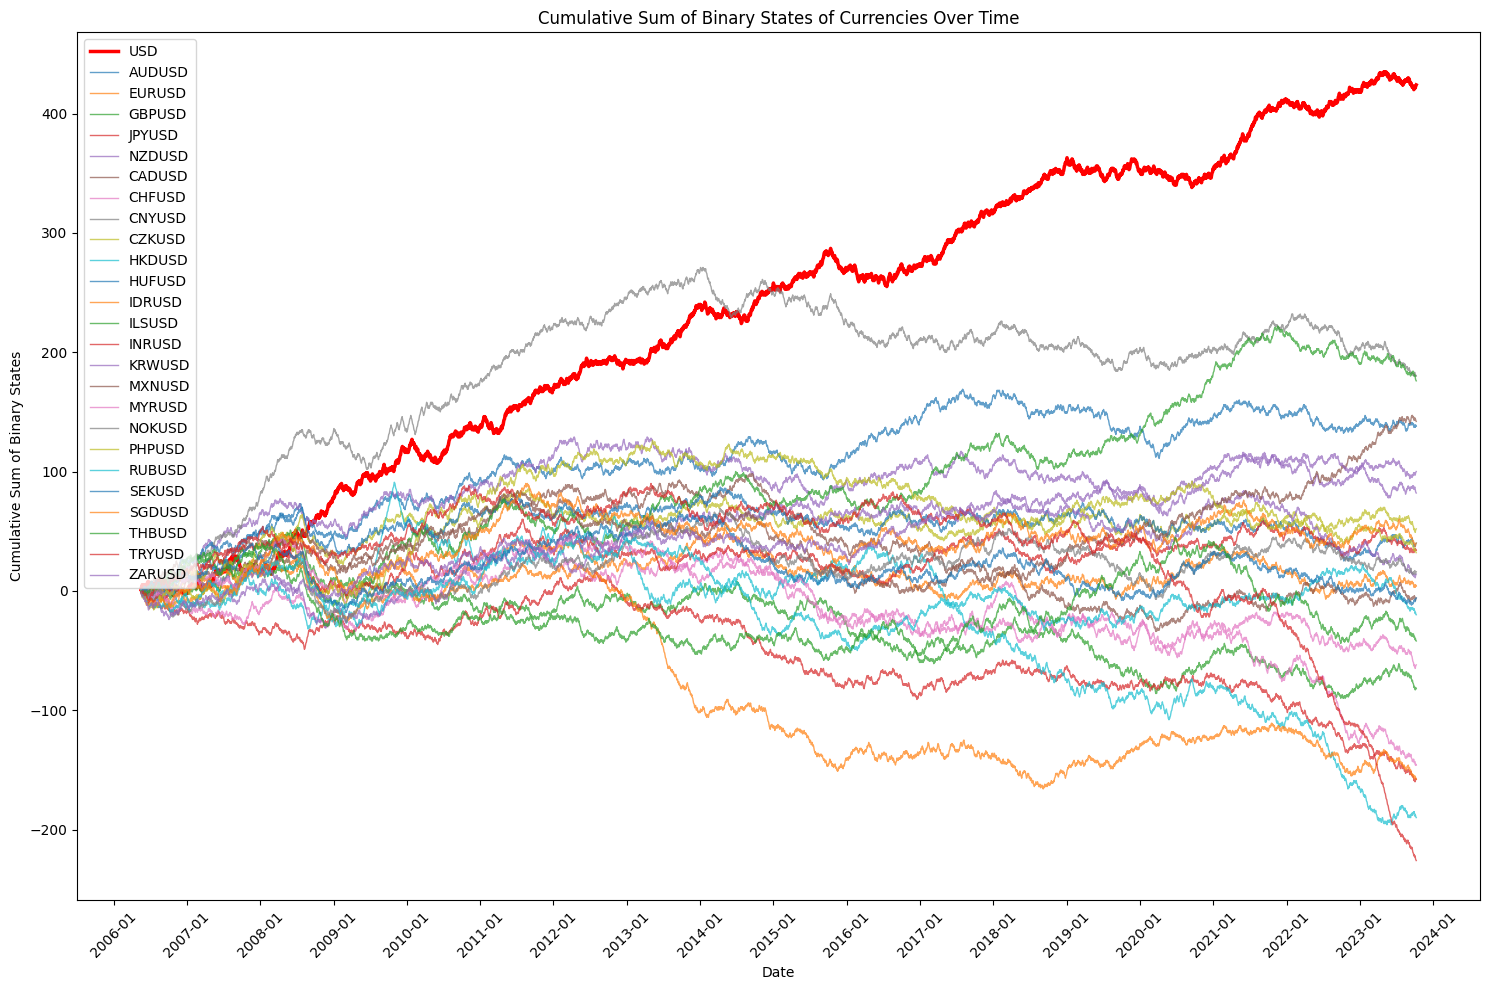

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def format_date_axis():
    """Formats the date axis with year and month."""
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)

def plot_cumulative_binary_states(data, cumsum_data, title, highlight_currency=None):
    """Plots the cumulative sum of binary states for given currencies."""
    plt.figure(figsize=(15, 10))
    for column in cumsum_data.columns:
        if column == highlight_currency:
            # Highlight the specified currency with a different style
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=2.5, color='red')
        else:
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=1, alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Sum of Binary States')
    plt.title(title)
    format_date_axis()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Read and process data
data_matrix_extended = pd.read_csv("Results/data_matrix_extended.csv")

# Convert the 'Date' column to datetime and sort the data
data_matrix_extended['Date'] = pd.to_datetime(data_matrix_extended['Date'])

# Cumulative sum of binary states
data_matrix_cumsum = data_matrix_extended.drop(columns=['Date']).cumsum()

# Plot with USD highlighted
plot_cumulative_binary_states(data_matrix_extended, data_matrix_cumsum, 
                            'Cumulative Sum of Binary States of Currencies Over Time', 
                            highlight_currency='USD')